#Abrir drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Importar bibliotecas

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torchvision import datasets
from torchvision.models import mobilenetv2, MobileNet_V2_Weights
from torch.optim import lr_scheduler
from torch.utils.data import random_split

In [3]:
import pandas as pd
import numpy as np
import os
import shutil
from tqdm.notebook import tqdm
from pathlib import Path
import cv2
import random

In [4]:
import time
from PIL import Image
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import time
import copy

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Definir seed

In [6]:
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
g = torch.Generator()
g.manual_seed(42)

#Preparação dos arquivos

## Abrir os arquivos

In [7]:
!cp /content/drive/MyDrive/Desafios_Brain/desafio_5/Brain_Tumor_FT.zip /content

In [8]:
!unzip Brain_Tumor_FT.zip

Archive:  Brain_Tumor_FT.zip
   creating: Brain Tumor/
  inflating: Brain Tumor/Image2091.jpg  
  inflating: Brain Tumor/Image2110.jpg  
  inflating: Brain Tumor/Image3621.jpg  
  inflating: Brain Tumor/Image3472.jpg  
  inflating: Brain Tumor/Image2112.jpg  
  inflating: Brain Tumor/Image3039.jpg  
  inflating: Brain Tumor/Image597.jpg  
  inflating: Brain Tumor/Image2397.jpg  
  inflating: Brain Tumor/Image2099.jpg  
  inflating: Brain Tumor/Image2123.jpg  
  inflating: Brain Tumor/Image2124.jpg  
  inflating: Brain Tumor/Image2403.jpg  
  inflating: Brain Tumor/Image3045.jpg  
  inflating: Brain Tumor/Image3058.jpg  
  inflating: Brain Tumor/Image2132.jpg  
  inflating: Brain Tumor/Image3062.jpg  
  inflating: Brain Tumor/Image3063.jpg  
  inflating: Brain Tumor/Image3068.jpg  
  inflating: Brain Tumor/Image3072.jpg  
  inflating: Brain Tumor/Image3073.jpg  
  inflating: Brain Tumor/Image2135.jpg  
  inflating: Brain Tumor/Image2136.jpg  
  inflating: Brain Tumor/Image3075.jpg  
  i

In [11]:
# renomer a pasta Brain Tumor (que foi extraída de "Brain_Tumor_FT.zip")
Brain_Tumor_FT = os.listdir("/content/Brain_Tumor")

In [12]:
Tumor_csv = pd.read_csv('/content/drive/MyDrive/Desafios_Brain/desafio_5/Brain_Tumor.csv')

### Criação das classes (pastas)

In [13]:
path = "/content/drive/MyDrive/Desafios_Brain/desafio_5/images"
path_train = "/train"
path_test = "/test"
path_validation = "/validation"
path_tumor = "/tumor"
path_non_tumor = "/non_tumor"

paths_mid = [path_train, path_test, path_validation]
path_end = [path_tumor, path_non_tumor]

In [14]:
path_imgs = "/content/Brain_Tumor"

In [15]:
if not os.path.exists(path):
    os.makedirs(path)
for var1 in paths_mid:
  if not os.path.exists(path + var1):
    os.makedirs(path + var1)
  for var2 in path_end:
    if not os.path.exists(path + var1 + var2):
        os.makedirs(path + var1 + var2)
    if not os.path.exists(path + var1 + var2):
        os.makedirs(path + var1 + var2)

### Divisão das imagens para test, train e validation

In [16]:
dataset_size = len(Brain_Tumor_FT)

In [17]:
train_size, test_size, validation_size = random_split(Tumor_csv, [0.7, 0.2, 0.1])

In [18]:
id_train_size = train_size.indices
id_test_size = test_size.indices
id_validation_size = validation_size.indices

### Filtro para separação das imagens

In [19]:
imgs = Tumor_csv[['Image', 'Class']]

In [20]:
values_imgs = imgs.values

In [21]:
values_train_size = values_imgs[id_train_size]
values_test_size = values_imgs[id_test_size]
values_validation_size = values_imgs[id_validation_size]

In [22]:
values_train_tumor = values_train_size[values_train_size[:,1] == 1]
values_test_tumor = values_test_size[values_test_size[:,1] == 1]
values_validation_tumor = values_validation_size[values_validation_size[:,1] == 1]

In [23]:
#values_tumor = [values_train_tumor[:,0], values_test_tumor[:,0], values_validation_tumor[:,0]]
values_tumor = {'train':values_train_tumor[:,0],'test':values_test_tumor[:,0],'validation':values_validation_tumor[:,0]}

In [24]:
values_train_non_tumor = values_train_size[values_train_size[:,1] == 0]
values_test_non_tumor = values_test_size[values_test_size[:,1] == 0]
values_validation_non_tumor = values_validation_size[values_validation_size[:,1] == 0]

In [25]:
#values_non_tumor = [values_train_non_tumor, values_test_non_tumor, values_validation_non_tumor]
values_non_tumor = {'train':values_train_non_tumor[:,0],'test':values_test_non_tumor[:,0], 'validation':values_validation_non_tumor[:,0]}

### Copiar imagens para seus respectivos diretórios

In [26]:
for tm, data in zip(['tumor', 'non_tumor'], [values_tumor, values_non_tumor]):
  for partition, file in data.items():
    #new_path = os.path.join(path, partition, tm)
    new_files = [os.path.join(path, partition, tm, f +'.jpg') for f in file]
    old_files = [os.path.join(path_imgs, f + '.jpg')for f in file]
    iter_data = tqdm(zip(new_files, old_files))
    for new, old in iter_data:
      iter_data.set_description(f'{partition}-{tm}-{new}')
      shutil.copy(old, new)

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

### Conferir quantidade de imagens em cada diretório

In [27]:
for dir in Path(path).rglob("*/"):
  if dir.is_dir():
    print(dir)
    print(len(list(dir.iterdir())))
    print("\n")

/content/drive/MyDrive/Desafios_Brain/desafio_5/images/train
2


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/test
2


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/validation
2


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/.ipynb_checkpoints
0


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/train/tumor
1680


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/train/non_tumor
2075


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/test/tumor
1157


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/test/non_tumor
1376


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/validation/tumor
723


/content/drive/MyDrive/Desafios_Brain/desafio_5/images/validation/non_tumor
808




# Criar rede CNN

## Configurar transformação par pré processamento das imagens

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.Resize((224,224))
     ])

batch_size = 16

## Separar set de treino, teste e validação

In [29]:
trainset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Desafios_Brain/desafio_5/images/train',
                                         transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2, generator=g)

testset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Desafios_Brain/desafio_5/images/test',
                                        transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, generator=g)

validationset = torchvision.datasets.ImageFolder(root='/content/drive/MyDrive/Desafios_Brain/desafio_5/images/validation',
                                        transform=transform)
validationloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=2, generator=g)

classes = ('tumor', 'non_tumor')

In [30]:
validationset.classes

['non_tumor', 'tumor']

In [31]:
dic_img = {}

for img in Brain_Tumor_FT:
  img2 = cv2.imread(os.path.join(path_imgs,img)).shape
  if img2 not in dic_img:
    dic_img[img2] = 0
  dic_img[img2] +=1

In [32]:
dic_img

{(240, 240, 3): 3762}

## Rede 1 - Criada do zero

In [ ]:
class CNN(nn.Module):
  #arquitetura da rede
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 8, 3, 1, 1) #3 canais da imagem inserida, retornar 6 imagens filtradas, filtro 5x5
    self.relu1 = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2) #maxpooling para pegar as features mais importantes
    self.conv2 = nn.Conv2d(8, 16, 3, 1, 1) #entra 6 imagens sai 16 filtro 5x5
    self.relu2 = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2)
    self.fc1 = nn.Linear(16*56*56, 2048)
    self.fc2 = nn.Linear(2048, 512)
    self.fc3 = nn.Linear(512, 128)
    self.fc4 = nn.Linear(128, 2)

  #compotamento da rede
  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)  #alimenta a fully connected layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

### Rede 2 - Criada utilizando transfer learning

In [33]:
cudnn.benchmark = True
plt.ion()

In [34]:
class CNN(nn.Module):
  #arquitetura da rede
  def __init__(self):
    super().__init__()
    self.model = mobilenetv2.mobilenet_v2(weights= MobileNet_V2_Weights.IMAGENET1K_V2)
    self.model = nn.Sequential(*list(self.model.children())[:-1])
    for param in self.model.parameters():
      param.requires_grad = False
    self.fc1 = nn.Linear(1280*7*7, 2048)
    self.fc2 = nn.Linear(2048, 128)
    self.fc4 = nn.Linear(128, 2)

  #compotamento da rede
  def forward(self, x):
    x = self.model(x)
    x = torch.flatten(x, 1)  #alimenta a fully connected layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc4(x)
    return x

## Definindo a função de perda e otimizador

In [35]:
device = 'cuda' if torch.cuda.is_available() else "cpu"

In [36]:
cnn = CNN().to(device)

Downloading: "https://download.pytorch.org/models/mobilenet_v2-7ebf99e0.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-7ebf99e0.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 96.3MB/s]


In [37]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn.parameters(), lr = 0.0001)

## Treinando o modelo

In [38]:
epochs = 20
best_score = float('inf')
tolerancia = 0.5
early_stop = 10
counter = 0
for epoch in range(epochs):
    print("early_stop: %s" % early_stop)
    print("counter: %s" % counter)
    print("best_score: %s" % best_score)
    if counter == early_stop:
      break
    train_loss = 0.0
    train = tqdm(trainloader)

    for data in train:
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Zera os gradientes das variáveis
        optimizer.zero_grad()
        outputs = cnn(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()  # Chame a função step com parênteses

        # Mostrar estatísticas
        train_loss += loss.item()
        train.set_description('loss: %.8f' % loss.item())

    validation = tqdm(validationloader)
    validation_loss = 0.0
    with torch.no_grad():
      for data in validation:
          inputs, labels = data
          inputs = inputs.to(device)
          labels = labels.to(device)
          outputs = cnn(inputs)
          loss = criterion(outputs, labels)

          validation_loss += loss.item()
          validation.set_description('error: %.8f' % loss.item())

    validation_loss = validation_loss/len(validationloader)
    train_loss = train_loss/len(trainloader)
    print("validation error: %.8f" % validation_loss)
    print("train error: %.8f" % train_loss)

    if validation_loss < best_score:
      torch.save(cnn.state_dict(), f="/content/drive/MyDrive/Desafios_Brain/desafio_5/model/cnn_model.pt")
      best_score = validation_loss
      counter = 0

    if abs(train_loss - validation_loss) > tolerancia:
      counter += 1
    elif counter :
      counter -= 1


print('Finished Training')

early_stop: 10
counter: 0
best_score: inf


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.15281729
train error: 0.33328123
early_stop: 10
counter: 0
best_score: 0.15281728875337156


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.07734348
train error: 0.15687955
early_stop: 10
counter: 0
best_score: 0.07734348442487465


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.05701037
train error: 0.09673204
early_stop: 10
counter: 0
best_score: 0.05701037082065529


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.04436370
train error: 0.06749059
early_stop: 10
counter: 0
best_score: 0.04436370108054025


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.02359123
train error: 0.04862810
early_stop: 10
counter: 0
best_score: 0.023591231354863716


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.02879804
train error: 0.03182874
early_stop: 10
counter: 0
best_score: 0.023591231354863716


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01665012
train error: 0.03636379
early_stop: 10
counter: 0
best_score: 0.016650120316328825


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.03603187
train error: 0.02678718
early_stop: 10
counter: 0
best_score: 0.016650120316328825


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01191850
train error: 0.03047228
early_stop: 10
counter: 0
best_score: 0.011918496016161106


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01484140
train error: 0.02491000
early_stop: 10
counter: 0
best_score: 0.011918496016161106


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01218340
train error: 0.01991282
early_stop: 10
counter: 0
best_score: 0.011918496016161106


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.00857514
train error: 0.02389220
early_stop: 10
counter: 0
best_score: 0.008575135131301388


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01151054
train error: 0.01745851
early_stop: 10
counter: 0
best_score: 0.008575135131301388


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.00689043
train error: 0.00747822
early_stop: 10
counter: 0
best_score: 0.006890427778357547


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01305210
train error: 0.01266341
early_stop: 10
counter: 0
best_score: 0.006890427778357547


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.00767914
train error: 0.01925545
early_stop: 10
counter: 0
best_score: 0.006890427778357547


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01445461
train error: 0.02022102
early_stop: 10
counter: 0
best_score: 0.006890427778357547


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01512829
train error: 0.01498621
early_stop: 10
counter: 0
best_score: 0.006890427778357547


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.01881927
train error: 0.01097276
early_stop: 10
counter: 0
best_score: 0.006890427778357547


  0%|          | 0/235 [00:00<?, ?it/s]

  0%|          | 0/159 [00:00<?, ?it/s]

validation error: 0.02010217
train error: 0.01043965
Finished Training


In [39]:
print(labels)

tensor([0, 1, 0, 0, 1], device='cuda:0')


## Salvar modelo

In [40]:
model_path = '/content/drive/MyDrive/Desafios_Brain/desafio_5/model/'
file_name = "cnn_modelo.pth"

if not os.path.exists(model_path):
  os.makedirs(model_path)

model = CNN()
weights = torch.load("/content/drive/MyDrive/Desafios_Brain/desafio_5/model/cnn_model.pt")
model.load_state_dict(weights)
model = model.to(device)


In [41]:
print(best_score)

0.006890427778357547


## Testar modelo

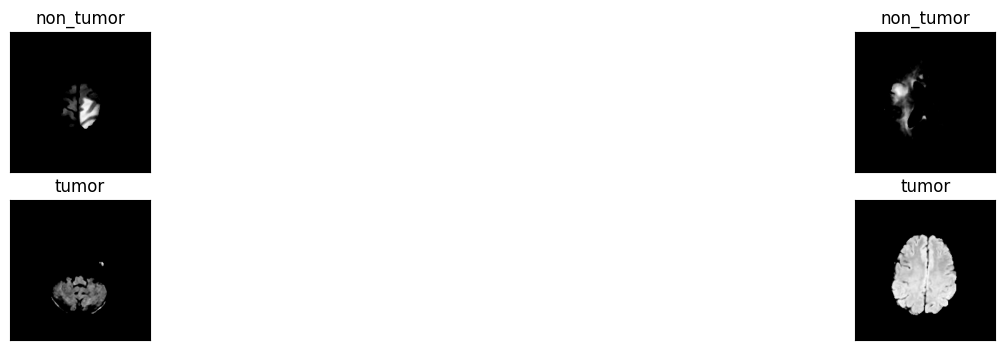

In [42]:
dataiter = iter(testloader)
images, labels = next(dataiter)

fig = plt.figure(figsize=(20,4))
for idx in np.arange(4):
  ax= fig.add_subplot(2, 4//2, idx+1, xticks=[], yticks=[])
  img = images[idx].numpy().transpose(1,2,0)
  plt.imshow(img)
  ax.set_title(classes[labels[idx]])

In [43]:
images = images.to(device)
outputs = cnn(images)
outputs

_, predicted = torch.max(outputs, 1)
print("predicted: ", ' '.join('%5s'% classes[predicted[j]]
                             for j in range(4)))

predicted:  non_tumor non_tumor tumor tumor


## Performace total do modelo

In [48]:
pred = []
labels = []

with torch.no_grad():
  for data in testloader:
    images, label = data
    images = images.to(device)
    label = label.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    pred += outputs.argmax(1).cpu().tolist()
    labels += label.cpu().tolist()

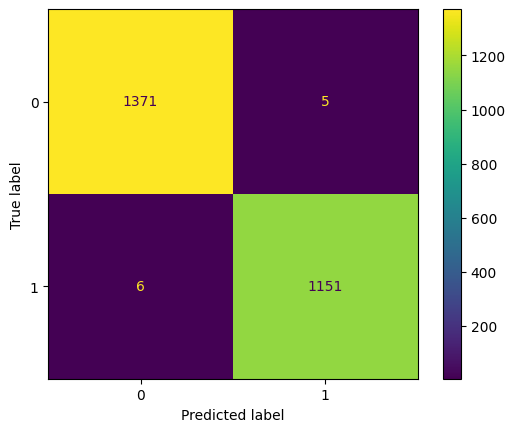

In [45]:
cm = confusion_matrix(labels, pred)
ConfusionMatrixDisplay(cm).plot()

In [52]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Mover dados para GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Accuracy no conjunto de teste: {accuracy:.4f}')

Accuracy no conjunto de teste: 0.9972
